In [216]:
import pandas as pd
import scanpy as sc
from warnings import filterwarnings
filterwarnings('ignore')
import os
import glob
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.cm as cm
import itertools
import gseapy as gp
import pandas as pd

### Get performance and plotting

This script will apply gene-set enrichment analysis to genes with different performance across priors and create a spider plot to visualize it

In [217]:
# load in data
dataset = 'replogle_rpe1'
use_hvg = True
dataset_name = dataset + ('_hvg' if use_hvg else '_full')

test_set_name = '5_fold_split' # '5_fold_split' or 'out_of_distribution_split'
null_label = 'zeros' # 'gaussian_normalized' or 'zeros'
if dataset == 'replogle_k562_essential' or dataset == 'replogle_rpe1':
    tolerance_epoch = 20

prior_list = ['DepMap_GeneEffect', 'GenePT_v1', 'GenePT_v2_large', 'STRING']
model_type = 'mvae_attention_vae_14_3'
threshold_method = 'distance' # distance or min_max

In [218]:
if threshold_method == 'min_max':
    if dataset == 'replogle_k562_essential':
        small_threshold = 0.42
        high_threshold = 0.59
    elif dataset == 'replogle_rpe1':
        small_threshold = 0.53
        high_threshold = 0.83
    csv_file_path = f'{dataset_name}/null_label_{null_label}/tolerance_epoch_{tolerance_epoch}/min_{small_threshold}_high_{high_threshold}/diff_genes.csv'
elif threshold_method == 'distance':
    distance_threshold = 0.4
    csv_file_path = f'{dataset_name}/null_label_{null_label}/tolerance_epoch_{tolerance_epoch}/distance_threshold_{distance_threshold}/diff_genes.csv'
gene_df = pd.read_csv(csv_file_path)

In [219]:
gene_df

,pert,Control_Gene_Expression,DepMap_GeneEffect,Geneformer,GenePT_v1,GenePT_v2_large,STRING,test_set_id,diff_genes,distance_to_diagonal,DepMap_GeneEffect_GenePT_v1_diff,DepMap_GeneEffect_GenePT_v2_large_diff,DepMap_GeneEffect_STRING_diff,GenePT_v1_GenePT_v2_large_diff,GenePT_v1_STRING_diff,GenePT_v2_large_STRING_diff,distance_threshold
0,DDX51,0.986523,0.432136,0.483319,0.192690,0.306407,0.227711,random_fold_1,0,0.055647,0.169314,0.088904,0.144551,0.080410,0.024764,0.055647,0.4
1,RPUSD3,0.875182,0.558714,0.535868,0.513379,0.597316,0.643976,random_fold_1,0,0.032993,0.032056,0.027296,0.060290,0.059352,0.092346,0.032993,0.4
2,GFER,0.505682,0.557417,0.580294,0.315386,0.474218,0.591434,random_fold_1,0,0.082884,0.171142,0.058830,0.024054,0.112311,0.195196,0.082884,0.4
3,CRKL,0.433358,0.279570,0.699040,0.373906,0.430016,0.559107,random_fold_1,0,0.091281,0.066706,0.106382,0.197663,0.039676,0.130957,0.091281,0.4
4,RPL19,0.479549,0.531144,0.489802,0.942946,0.422939,0.521057,random_fold_1,0,0.069380,0.291188,0.076512,0.007133,0.367701,0.298321,0.069380,0.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1926,BAP1,0.864582,1.012917,0.781282,0.615440,0.766941,0.560153,random_fold_5,0,0.146221,0.281059,0.173932,0.320153,0.107127,0.039094,0.146221,0.4
1927,ELL,1.044509,0.927160,0.278670,0.539629,0.941547,0.321890,random_fold_5,1,0.438164,0.274026,0.010174,0.427991,0.284199,0.153965,0.438164,0.4
1928,SON,0.439862,0.438527,0.426001,0.425708,0.556950,0.396461,random_fold_5,0,0.113483,0.009064,0.083738,0.029745,0.092802,0.020681,0.113483,0.4
1929,EEF1A1,0.439781,0.726882,0.449855,0.667667,0.672177,0.681913,random_fold_5,0,0.006885,0.041871,0.038682,0.031798,0.003189,0.010073,0.006885,0.4


In [220]:
diff_gene_list = gene_df[gene_df['diff_genes'] == 1]['pert'].tolist()
print('len(diff_gene_list)', len(diff_gene_list))

len(diff_gene_list) 362


In [221]:
adata_file_path = '/home/che/perturb-project/git/gene_ptb_prediction/scdata_file_path.csv'
adata_file = pd.read_csv(adata_file_path)
adata_path = adata_file[(adata_file['dataset'] == dataset) & (adata_file['use_hvg'] == use_hvg)]['file_path'].values[0]
adata = sc.read(adata_path)
print('Read adata from', adata_path)

Read adata from /home/che/perturb-project/predict_model/dataset/replogle_rpe1/rpe1_normalized_hvg.h5ad


### Step 1. Run GSEAPY in diff_gene_list

In [222]:
background_list = 'all_perturbations'

if background_list == 'measured_genes':
    # background_genes = adata.var['gene_name'].unique().tolist()
    raise KeyError('Should use all_perturbations')
elif background_list == 'all_perturbations':
    background_genes = adata.obs['gene'].unique().tolist()

print('len(background_genes)', len(background_genes))

len(background_genes) 2265


In [223]:
gene_set_name = 'GO_Biological_Process_2018' #'GO_Biological_Process_2018'
# Run enrichment analysis
enr = gp.enrichr(
        gene_list=diff_gene_list,
        gene_sets=gene_set_name, 
        organism='Human',
        background=background_genes,
        # description='Low MMD Gene Set Analysis',
        outdir=None,
        cutoff=0.05,
    )
len(background_genes)

2265

In [224]:
enr_df = enr.results
enr_df = enr_df[enr_df['Adjusted P-value'] < 0.05]
enr_df_head = enr_df.head(8) #let's look at the top 8 pathways
enr_df_head

,Gene_set,Term,P-value,Adjusted P-value,Old P-value,Old adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2018,protein transmembrane import into intracellula...,6.794759e-07,0.001146,0,0,13.014857,184.836273,CHCHD4;DNAJC19;TOMM40;SAMM50;GRPEL1;TIMM9;PAM1...
1,GO_Biological_Process_2018,establishment of protein localization to mitoc...,1.658421e-05,0.013980,0,0,8.488400,93.432329,CHCHD4;DNAJC19;TOMM40;GRPEL1;TIMM9;PAM16;TIMM1...
2,GO_Biological_Process_2018,protein targeting to mitochondrion (GO:0006626),3.287692e-05,0.018002,0,0,6.490286,66.997529,CHCHD4;DNAJC19;TOMM40;SAMM50;GRPEL1;TIMM9;PAM1...
3,GO_Biological_Process_2018,rRNA processing (GO:0006364),4.270945e-05,0.018002,0,0,2.212601,22.261180,DDX27;RPL31;RPL34;POP4;WDR3;RPLP0;NOP2;RPL36A;...
4,GO_Biological_Process_2018,rRNA metabolic process (GO:0016072),1.094337e-04,0.036901,0,0,2.139375,19.511510,DDX27;RPL31;RPL34;POP4;WDR3;RPLP0;RPL36A;NOLC1...
5,GO_Biological_Process_2018,ribosome biogenesis (GO:0042254),1.382533e-04,0.038849,0,0,2.054320,18.255559,DDX27;RPL31;RPL34;POP4;WDR3;RPLP0;RPL36A;NOLC1...


In [225]:
# remove (GO:XXXXXXX) from the pathway names
enr_df_head['Term'] = enr_df_head['Term'].str.replace(r"\(GO:\d+\)", "", regex=True)
enr_df_head['Term'] = enr_df_head['Term'].str.replace(r" Homo sapiens R-HSA-\d+", "", regex=True)
enr_df_head

,Gene_set,Term,P-value,Adjusted P-value,Old P-value,Old adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2018,protein transmembrane import into intracellula...,6.794759e-07,0.001146,0,0,13.014857,184.836273,CHCHD4;DNAJC19;TOMM40;SAMM50;GRPEL1;TIMM9;PAM1...
1,GO_Biological_Process_2018,establishment of protein localization to mitoc...,1.658421e-05,0.013980,0,0,8.488400,93.432329,CHCHD4;DNAJC19;TOMM40;GRPEL1;TIMM9;PAM16;TIMM1...
2,GO_Biological_Process_2018,protein targeting to mitochondrion,3.287692e-05,0.018002,0,0,6.490286,66.997529,CHCHD4;DNAJC19;TOMM40;SAMM50;GRPEL1;TIMM9;PAM1...
3,GO_Biological_Process_2018,rRNA processing,4.270945e-05,0.018002,0,0,2.212601,22.261180,DDX27;RPL31;RPL34;POP4;WDR3;RPLP0;NOP2;RPL36A;...
4,GO_Biological_Process_2018,rRNA metabolic process,1.094337e-04,0.036901,0,0,2.139375,19.511510,DDX27;RPL31;RPL34;POP4;WDR3;RPLP0;RPL36A;NOLC1...
5,GO_Biological_Process_2018,ribosome biogenesis,1.382533e-04,0.038849,0,0,2.054320,18.255559,DDX27;RPL31;RPL34;POP4;WDR3;RPLP0;RPL36A;NOLC1...


### Step 2. Calculate mean prediction errors for each gene set using different priors

In [226]:
if dataset_name == 'replogle_rpe1_hvg':
    max_mmd = 1.1
elif dataset_name == 'replogle_k562_essential_hvg':
    max_mmd = 1.3
elif dataset_name == 'replogle_k562_gwps_hvg':
    max_mmd = 1.3

In [227]:
gene_sets_mean_scores = pd.DataFrame()

for row in enr_df_head.iterrows():
    print(row[1]['Term'])
    gene_list_temp = row[1]['Genes']
    gene_list_temp = gene_list_temp.split(';')
    print('len(gene_list_temp)', len(gene_list_temp))

    gene_df_temp = gene_df[gene_df['pert'].isin(gene_list_temp)]
    # calculate row mean
    gene_df_temp = gene_df_temp[prior_list].mean(axis=0)
    gene_df_temp = gene_df_temp.to_frame().T
    # print(gene_df_temp)
    # set to 1- value/max(mmd)
    gene_df_temp = 1 - gene_df_temp/max_mmd
    gene_df_temp['Term'] = row[1]['Term']
    gene_df_temp['Adjusted P-value'] = row[1]['Adjusted P-value']
    gene_df_temp['Genes'] = row[1]['Genes']
    
    # concat to gene_sets_mean_scores
    gene_sets_mean_scores = pd.concat([gene_sets_mean_scores, gene_df_temp])
print('max_mmd', max_mmd)

protein transmembrane import into intracellular organelle 
len(gene_list_temp) 12
establishment of protein localization to mitochondrion 
len(gene_list_temp) 11
protein targeting to mitochondrion 
len(gene_list_temp) 12
rRNA processing 
len(gene_list_temp) 44
rRNA metabolic process 
len(gene_list_temp) 42
ribosome biogenesis 
len(gene_list_temp) 45
max_mmd 1.1


**Note that to represent the prediction accuracy, we use -MMD (the higher, the better)**

In [228]:
gene_sets_mean_scores

,DepMap_GeneEffect,GenePT_v1,GenePT_v2_large,STRING,Term,Adjusted P-value,Genes
0,0.179168,0.150509,0.201033,0.017275,protein transmembrane import into intracellula...,0.001146,CHCHD4;DNAJC19;TOMM40;SAMM50;GRPEL1;TIMM9;PAM1...
0,0.178116,0.162766,0.216578,0.050134,establishment of protein localization to mitoc...,0.013980,CHCHD4;DNAJC19;TOMM40;GRPEL1;TIMM9;PAM16;TIMM1...
0,0.179168,0.150509,0.201033,0.017275,protein targeting to mitochondrion,0.018002,CHCHD4;DNAJC19;TOMM40;SAMM50;GRPEL1;TIMM9;PAM1...
0,0.397198,0.151765,0.245638,0.178396,rRNA processing,0.018002,DDX27;RPL31;RPL34;POP4;WDR3;RPLP0;NOP2;RPL36A;...
0,0.417836,0.151313,0.206087,0.122311,rRNA metabolic process,0.036901,DDX27;RPL31;RPL34;POP4;WDR3;RPLP0;RPL36A;NOLC1...
0,0.396972,0.108541,0.237618,0.097228,ribosome biogenesis,0.038849,DDX27;RPL31;RPL34;POP4;WDR3;RPLP0;RPL36A;NOLC1...


In [229]:
# save the csv file
if threshold_method == 'min_max':
    gene_sets_mean_scores.to_csv(f'{dataset_name}/null_label_{null_label}/tolerance_epoch_{tolerance_epoch}/min_{small_threshold}_high_{high_threshold}/bg_{background_list}_gs_{gene_set_name}_scores.csv')
elif threshold_method == 'distance':
    gene_sets_mean_scores.to_csv(f'{dataset_name}/null_label_{null_label}/tolerance_epoch_{tolerance_epoch}/distance_threshold_{distance_threshold}/bg_{background_list}_gs_{gene_set_name}_scores.csv')


### Step 3. Draw a spider plot

In [230]:
df = gene_sets_mean_scores.copy()

In [231]:
df['Term'].unique().tolist()

['protein transmembrane import into intracellular organelle ',
 'establishment of protein localization to mitochondrion ',
 'protein targeting to mitochondrion ',
 'rRNA processing ',
 'rRNA metabolic process ',
 'ribosome biogenesis ']

In [232]:
# remove heading and trailing whitespaces from df['Term']
df['Term'] = df['Term'].str.strip()

In [233]:
# Function to insert a newline at the nearest space if the term is too long
def insert_newline(term, max_length=20):
    if len(term) <= max_length:
        return term  # No need to modify if term length is within limit
    
    # Split the term into words
    words = term.split(' ')
    result = []
    current_length = 0

    for word in words:
        # Check if adding the next word exceeds the max length
        if current_length + len(word) + len(result) > max_length:
            result.append('\n')  # Insert newline
            current_length = 0  # Reset length count
        result.append(word)
        current_length += len(word)
    
    return ' '.join(result).replace(' \n ', '\n')  # Clean up any excess spaces around newlines

# Apply the function to the 'Term' column
df['Term'] = df['Term'].apply(lambda x: insert_newline(x, max_length=10))

In [234]:
df['Term'] = df['Term'].str.lstrip('\n ')
df['Term'] = df['Term'].str.replace('RNA\nsplicing,\nvia\ntransesterification\nreactions\nwith\nbulged\nadenosine\nas\nnucleophile', 'RNA splicing,\nvia\ntransesterification\nreactions with\nbulged adenosine\nas nucleophile')
df['Term'] = df['Term'].str.replace('maturation\nof\nSSU-rRNA\nfrom\ntricistronic\nrRNA\ntranscript\n(SSU-rRNA,\n5.8S\nrRNA,\nLSU-rRNA)', 'maturation\nof\nSSU-rRNA from\ntricistronic\nrRNA\ntranscript\n(SSU-rRNA,\n5.8S rRNA,\nLSU-rRNA)')
df['Term'] = df['Term'].str.replace('Nonsense\nMediated\nDecay\n(NMD)\nenhanced\nby\nthe\nExon\nJunction\nComplex\n(EJC)', 'Nonsense\nMediated\nDecay (NMD)\nenhanced by\nthe Exon Junction\nComplex (EJC)')
df['Term'] = df['Term'].str.replace('Nonsense\nMediated\nDecay\n(NMD)\nindependent\nof\nthe\nExon\nJunction\nComplex\n(EJC)', 'Nonsense\nMediated\nDecay (NMD)\nindependent of\nthe Exon Junction\nComplex (EJC)')
df['Term'] = df['Term'].str.replace('Nonsense-Mediated\nDecay\n(NMD)', 'Nonsense-\nMediated\nDecay\n(NMD)')
df['Term'] = df['Term'].str.replace('SRP-dependent\ncotranslational\nprotein\ntargeting\nto\nmembrane', 'SRP-dependent\ncotranslational\nprotein targeting\nto membrane')
df['Term'] = df['Term'].str.replace('Major\npathway\nof\nrRNA\nprocessing\nin\nthe\nnucleolus', 'Major pathway\nof rRNA\nprocessing\nin the\nnucleolus')
df['Term'] = df['Term'].str.replace("mRNA decay\nby 3'\nto\n5'\nexoribonuclease", "mRNA decay\nby 3' to 5'\nexoribonuclease")
df['Term'] = df['Term'].str.replace("Tristetraprolin\n(TTP,\nZFP36)\nbinds\nand\ndestabilizes\nmRNA", "Tristetraprolin\n(TTP, ZFP36)\nbinds and\ndestabilizes\nmRNA")
df['Term'] = df['Term'].str.replace("Butyrate\nResponse\nFactor\n1\n(BRF1)\nbinds\nand\ndestabilizes\nmRNA", "Butyrate\nResponse\nFactor 1\n(BRF1)\nbinds and\ndestabilizes mRNA")
df['Term'] = df['Term'].str.replace("KSRP\n(KHSRP)\nbinds\nand\ndestabilizes\nmRNA", "KSRP\n(KHSRP)\nbinds and\ndestabilizes\nmRNA")
df['Term'] = df['Term'].str.replace("GTP\nhydrolysis\nand\njoining\nof\nthe\n60S\nribosomal\nsubunit", "GTP hydrolysis\nand joining\nof the\n60S ribosomal\nsubunit")

In [235]:
df['Term'].unique().tolist()

['protein\ntransmembrane\nimport\ninto\nintracellular\norganelle',
 'establishment\nof\nprotein\nlocalization\nto\nmitochondrion',
 'protein\ntargeting\nto\nmitochondrion',
 'rRNA\nprocessing',
 'rRNA\nmetabolic\nprocess',
 'ribosome\nbiogenesis']

In [236]:
# Dictionary specifying terms and their desired positions (0-based index) GO-terms
preferred_order = {
    # unique but long
    'nuclear-transcribed\nmRNA\ncatabolic\nprocess,\nnonsense-mediated\ndecay': 4,
    'nuclear-transcribed\nmRNA\ncatabolic\nprocess': 2,
    'RNA splicing,\nvia\ntransesterification\nreactions with\nbulged adenosine\nas nucleophile':0,

    # repeated
    'ribosome\nbiogenesis': 3, #dc
    'rRNA\nmetabolic\nprocess': 1, #dc
    'rRNA\nprocessing': 0, #dc
    'ncRNA\nprocessing': 5,
    'mRNA\nsplicing,\nvia\nspliceosome': 7,
    'RNA\nprocessing': 6,
    'establishment\nof\nprotein\nlocalization\nto\nmitochondrion': 2, #dc
    'protein\ntransmembrane\nimport\ninto\nintracellular\norganelle': 4, #dc
    'protein\ntargeting\nto\nmitochondrion': 5, # don't change

    # k562
    'rRNA\nmetabolic\nprocess': 1,
    'maturation\nof\nSSU-rRNA': 6,
    # 'nuclear-transcribed\nmRNA\ncatabolic\nprocess': 2,
    "nuclear-transcribed\nmRNA\ncatabolic\nprocess,\nexonucleolytic,\n3'-5'": 2,
    "U4 snRNA\n3'-end\nprocessing": 4,
    'rRNA\ncatabolic\nprocess': 7,


    # Reactome --------------------------------
    'Mitochondrial\nprotein\nimport': 0,
    'Metabolism\nof\nproteins': 1,
    'Gene\nExpression': 2,
    'Major pathway\nof rRNA\nprocessing\nin the\nnucleolus': 1,
    'rRNA\nmodification\nin the\nnucleus':3,
    "mRNA decay\nby 3' to 5'\nexoribonuclease": 7,
    "Tristetraprolin\n(TTP, ZFP36)\nbinds and\ndestabilizes\nmRNA": 6,
    "Butyrate\nResponse\nFactor 1\n(BRF1)\nbinds and\ndestabilizes mRNA": 5,
    "KSRP\n(KHSRP)\nbinds and\ndestabilizes\nmRNA": 4
}

In [237]:
categories = df['Term'].tolist()

# Initialize ordered categories with None to fill the positions later
ordered_categories = [None] * len(categories)

# List to hold terms not specified in preferred_order
remaining_categories = [term for term in categories if term not in preferred_order]

# Place terms in specified positions
for term, position in preferred_order.items():
    if term in categories:
        print(f"Placing '{term}' at position {position}")
        assert ordered_categories[position] is None, f"Position {position} is already filled, term: {term}"
        ordered_categories[position] = term

# Fill remaining positions with terms not specified in preferred_order
filled_index = 0
for term in remaining_categories:
    # Find the next available position (None) in ordered_categories
    while filled_index < len(ordered_categories) and ordered_categories[filled_index] is not None:
        filled_index += 1
    if filled_index < len(ordered_categories):
        ordered_categories[filled_index] = term

n_categories = len(ordered_categories)
# Print the result for verification
print(ordered_categories)

Placing 'ribosome
biogenesis' at position 3
Placing 'rRNA
metabolic
process' at position 1
Placing 'rRNA
processing' at position 0
Placing 'establishment
of
protein
localization
to
mitochondrion' at position 2
Placing 'protein
transmembrane
import
into
intracellular
organelle' at position 4
Placing 'protein
targeting
to
mitochondrion' at position 5
['rRNA\nprocessing', 'rRNA\nmetabolic\nprocess', 'establishment\nof\nprotein\nlocalization\nto\nmitochondrion', 'ribosome\nbiogenesis', 'protein\ntransmembrane\nimport\ninto\nintracellular\norganelle', 'protein\ntargeting\nto\nmitochondrion']


In [238]:
# Adjust other parts of the plot using ordered categories
angles = [n / float(n_categories) * 2 * np.pi for n in range(n_categories)]
angles += angles[:1]

# Create a mapping of term positions from original categories to ordered categories
category_order_mapping = {term: idx for idx, term in enumerate(categories)}
new_order_indices = [category_order_mapping[term] for term in ordered_categories if term in category_order_mapping]

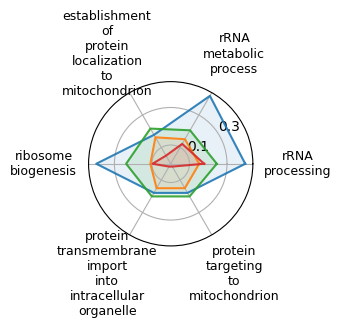

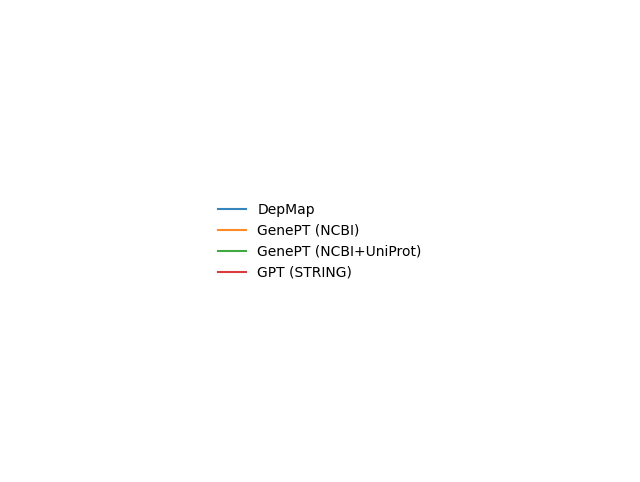

In [239]:
# Create a function to draw a spider plot for different priors
def plot_spider(df):
    priors = ['DepMap_GeneEffect', 'GenePT_v1', 'GenePT_v2_large', 'STRING']
    cleaned_names = ['DepMap', 'GenePT (NCBI)', 'GenePT (NCBI+UniProt)', 'GPT (STRING)']

    # priors = ['DepMap_GeneEffect', 'GenePT_v1', 'GenePT_v2_large']
    # cleaned_names = ['DepMap', 'GenePT (NCBI)', 'GenePT (NCBI+UniProt)']

    # reset names to be cleaned_names
    df.rename(columns={p: cleaned_names[i] for i, p in enumerate(priors)}, inplace=True)

    # Initialize spider plot
    fig, ax = plt.subplots(figsize=(3.5, 3.5), subplot_kw=dict(polar=True))
    
    # Draw one axe per gene set and add labels
    plt.xticks(angles[:-1], ordered_categories, color='black', size=9)
    ax.tick_params(axis='x', pad=22)

    # Draw y-labels
    ax.set_rlabel_position(32)
    if dataset_name == 'replogle_k562_essential_hvg':
        plt.yticks([0.1, 0.3, 0.5], ["0.1", "0.3", "0.5"])
    elif dataset_name == 'replogle_rpe1_hvg':
        plt.yticks([0.1, 0.3, 0.5], ["0.1", "0.3", "0.5"])

    # Plot data for each prior
    for prior in cleaned_names:
        values = df[prior].values.flatten().tolist()
        reordered_values = [values[idx] for idx in new_order_indices]  # Reorder the values
        reordered_values += reordered_values[:1]  # Repeat the first value to close the circular graph
        ax.plot(angles, reordered_values, linewidth=1.5, linestyle='solid', label=prior, alpha=0.9)
        ax.fill(angles, reordered_values, alpha=0.1)
        
    # adjust the tick labels font size
    plt.xticks(fontsize=9)
    # Add title and legend
    # plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5), ncol=len(cleaned_names), frameon=False, fontsize=6)
    plt.legend([], [], frameon=False)
    plt.tight_layout()
    if threshold_method == 'min_max':
        plt.savefig(f'{dataset_name}/null_label_{null_label}/tolerance_epoch_{tolerance_epoch}/min_{small_threshold}_high_{high_threshold}/bg_{background_list}_gs_{gene_set_name}_spider_plot.svg', format='svg')
        plt.savefig(f'{dataset_name}/null_label_{null_label}/tolerance_epoch_{tolerance_epoch}/min_{small_threshold}_high_{high_threshold}/bg_{background_list}_gs_{gene_set_name}_spider_plot.png', dpi = 300)
    elif threshold_method == 'distance':
        plt.savefig(f'{dataset_name}/null_label_{null_label}/tolerance_epoch_{tolerance_epoch}/distance_threshold_{distance_threshold}/bg_{background_list}_gs_{gene_set_name}_spider_plot.svg', format='svg')
        plt.savefig(f'{dataset_name}/null_label_{null_label}/tolerance_epoch_{tolerance_epoch}/distance_threshold_{distance_threshold}/bg_{background_list}_gs_{gene_set_name}_spider_plot.png', format='png', dpi = 300)
    plt.show()

    # Create a new figure for the legend only
    fig_legend, ax_legend = plt.subplots(figsize=(8, 6))
    ax_legend.axis('off')
    legend = ax.legend(loc='center', ncol=len(cleaned_names), frameon=False, fontsize=8)
    fig_legend.legend(handles=legend.legendHandles, labels=cleaned_names, loc='center', ncol=1, frameon=False)
    
    # Save the legend figure
    if threshold_method == 'min_max':
        fig_legend.savefig(f'{dataset_name}/null_label_{null_label}/tolerance_epoch_{tolerance_epoch}/min_{small_threshold}_high_{high_threshold}/legend.svg', format='svg')
        fig_legend.savefig(f'{dataset_name}/null_label_{null_label}/tolerance_epoch_{tolerance_epoch}/min_{small_threshold}_high_{high_threshold}/legend.png', dpi=300)
    elif threshold_method == 'distance':
        fig_legend.savefig(f'{dataset_name}/null_label_{null_label}/tolerance_epoch_{tolerance_epoch}/distance_threshold_{distance_threshold}/legend.svg', format='svg')
        fig_legend.savefig(f'{dataset_name}/null_label_{null_label}/tolerance_epoch_{tolerance_epoch}/distance_threshold_{distance_threshold}/legend.png', dpi=300)
    plt.show()
    
# Plot the spider plot
plot_spider(df)